Gradient ascent to visualize the effect of the metrics

In [199]:
from itertools import product

import torch
import torchvision
from torchvision.datasets import CIFAR10

import matplotlib as mpl
import matplotlib.pyplot as plt

from labproject import metrics
from labproject.embeddings import EmbeddingNet, FIDEmbeddingNet
from labproject.external.inception_v3 import InceptionV3, get_inception_v3_activations

In [200]:
dataset = CIFAR10('../../data', train=True, download=True)

Files already downloaded and verified


In [201]:
def sample_from_class(dataset, class_idx, n_samples=16, to_tensor=True):
    idxs = torch.where(torch.tensor(dataset.targets) == class_idx)[0]
    idxs = idxs[torch.randperm(len(idxs))[:n_samples]]
    if to_tensor:
        return torch.stack([torchvision.transforms.ToTensor()(dataset[idx][0]) for idx in idxs])
    return [dataset[idx][0] for idx in idxs]

In [218]:
class TwoSampleSet(torch.utils.data.Dataset):

    def __init__(self, dataset, class1, class2, n_samples=16, two_requires_grad=True):
        self.class1 = sample_from_class(dataset, class1, n_samples).to("cuda")       
        self.class2 = sample_from_class(dataset, class2, n_samples).to("cuda")
        self.class2.requires_grad = two_requires_grad
        self.n_samples = n_samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.activations1[idx], self.class2[idx].clip(0, 1)

    def precompute_activations(self, embedding_net):
        self.activations1 = get_inception_v3_activations(embedding_net, self.class1)

    def plot_grid(self, which=1, width=4, height=4, figsize=[4, 4]):

        if which == 1:
            data = twosampleset.class1
        elif which == 2:
            data = twosampleset.class2

        fig, ax = plt.subplots(width, height, figsize = figsize)

        for idx, (i, j) in enumerate(product(range(width), range(height))):
            try:
                img = data[idx]
            except IndexError:
                break
            if isinstance(img, torch.Tensor):
                img = img.detach().cpu().numpy().transpose((1, 2, 0)).clip(0, 1)
            ax[i, j].imshow(img)
            ax[i, j].set_axis_off()
        plt.subplots_adjust(wspace=0.1, hspace=0)


class TwoSampleSetNoise(TwoSampleSet):

    def __init__(self, dataset, class1, n_samples=16, two_requires_grad=True):
        self.class1 = sample_from_class(dataset, class1, n_samples).to("cuda")
        self.class2 = torch.Tensor(n_samples, 3, 32, 32).normal_(self.class1.mean(), self.class1.std()).to("cuda")
        self.class2.requires_grad = two_requires_grad
        self.n_samples = n_samples

    def __getitem__(self, idx):
        return self.activations1[idx], torch.nn.functional.sigmoid(self.class2[idx])

    def plot_grid(self, which=1, width=4, height=4, figsize=[4, 4]):

        if which == 1:
            data = twosampleset.class1
        elif which == 2:
            data = twosampleset.class2

        fig, ax = plt.subplots(width, height, figsize = figsize)

        for idx, (i, j) in enumerate(product(range(width), range(height))):
            try:
                if which == 1:
                    img = data[idx]
                elif which == 2:
                    img = torch.nn.functional.sigmoid(data[idx])
            except IndexError:
                break
            if isinstance(img, torch.Tensor):
                img = img.detach().cpu().numpy().transpose((1, 2, 0))
            ax[i, j].imshow(img)
            ax[i, j].set_axis_off()
        plt.subplots_adjust(wspace=0.1, hspace=0)

In [219]:
twosampleset = TwoSampleSetNoise(dataset, 0, n_samples=128)
# twosampleset = TwoSampleSet(dataset, 0, 1, n_samples=128)

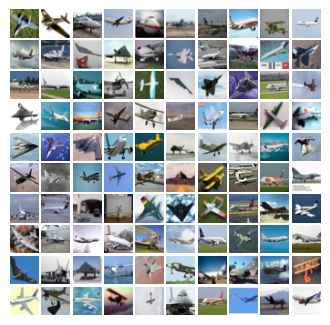

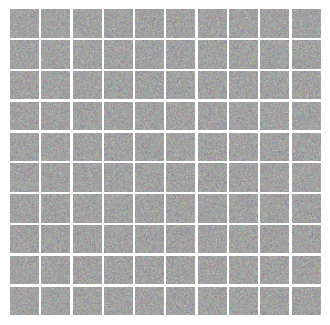

In [220]:
twosampleset.plot_grid(1, width=10, height=10)
twosampleset.plot_grid(2, width=10, height=10)

In [221]:
embedding_net = InceptionV3().to("cuda")
def get_inception_v3_activations_with_grad(model, images):
    """
    Get activations from the InceptionV3 model for the given images.

    Args:
        model (torch.nn.Module): The InceptionV3 model.
        images (torch.Tensor): The images for which to compute the activations.

    Returns:
        list: A list of torch.Tensor containing the activations from the model.
    """
    model.eval()
    pred = model(images)[0]
    pred = pred.squeeze(3).squeeze(2)
    return pred

def get_inception_v3_activations(model, images):
    """
    Get activations from the InceptionV3 model for the given images.

    Args:
        model (torch.nn.Module): The InceptionV3 model.
        images (torch.Tensor): The images for which to compute the activations.

    Returns:
        list: A list of torch.Tensor containing the activations from the model.
    """

    with torch.no_grad():
        pred = model(images)[0]

    # print(pred)
    pred = pred.squeeze(3).squeeze(2)
    return pred

In [222]:
twosampleset.precompute_activations(embedding_net)

In [223]:
dataloader = torch.utils.data.DataLoader(twosampleset, batch_size=32, shuffle=True)

In [224]:
n_epochs = 2000
from torch.optim.lr_scheduler import CosineAnnealingLR

optim = torch.optim.Adam([dataloader.dataset.class2], lr=0.005)#, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optim, T_max=n_epochs, eta_min=0.001)

In [225]:
from tqdm.auto import tqdm

  0%|          | 0/2000 [00:00<?, ?it/s]

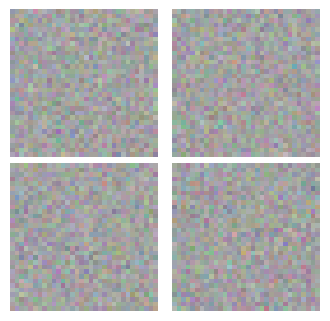

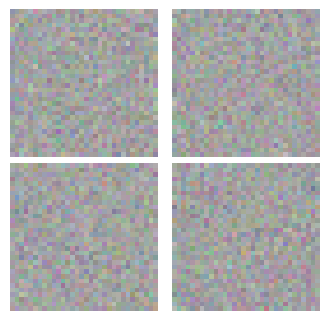

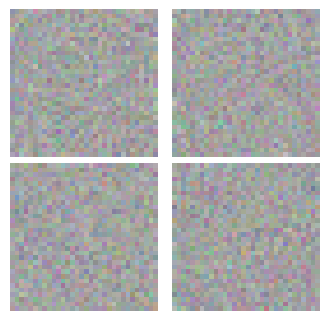

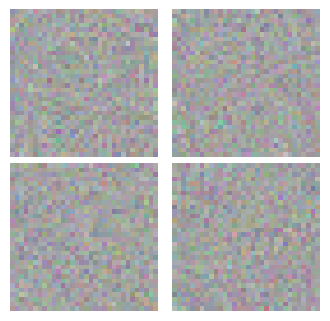

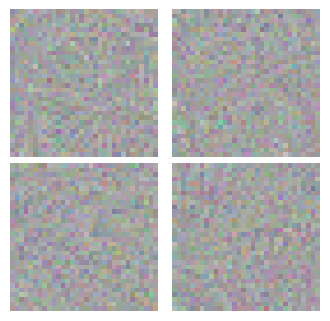

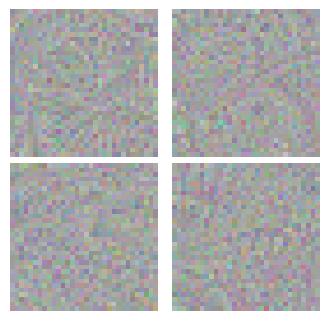

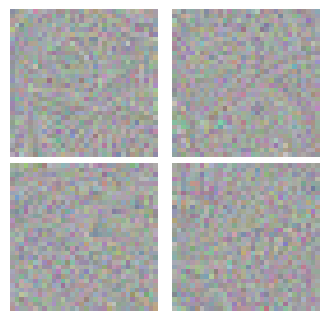

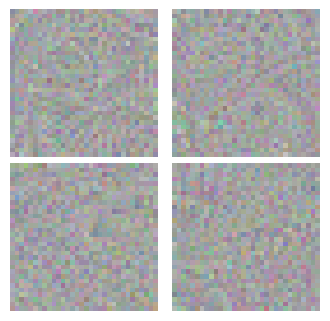

In [ ]:
losses = []

_tqdm = tqdm(range(n_epochs))
for epoch in _tqdm:
    if epoch % 10 == 0:
        with torch.no_grad():
            twosampleset.plot_grid(2, width=2, height=2)
            plt.show()
    for activations1, batch_class2 in dataloader:
        optim.zero_grad()
        activations2 = get_inception_v3_activations_with_grad(embedding_net, batch_class2)
        loss = metrics.sliced_wasserstein.sliced_wasserstein_distance(activations1, activations2, device="cuda")
        loss.backward()
        losses.append(loss.item())
        optim.step()
        _tqdm.set_postfix(dict(loss=loss.item()))
    # scheduler.step()
        # _tqdm.update()
        
_tqdm.close()

In [ ]:
plt.hist(torch.nn.functional.sigmoid(twosampleset.class2).detach().flatten().cpu())

In [ ]:
plt.plot(losses)
plt.yscale('log')
plt.xscale('log')

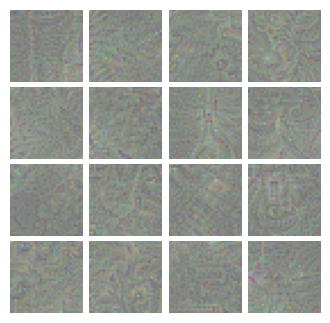

In [213]:
twosampleset.plot_grid(2, width=4, height=4)